<a href="https://colab.research.google.com/github/ayushtyagi04/Amazon-clone/blob/main/AyushTyagi_ABTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1. Simulate Data

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
np.random.seed(42)

In [ ]:
#Assume 10,000 visitors each
n_A , p_A = 10_000 , 0.10   #Variant A: 10% true conversion
n_B , p_B = 10_000 , 0.12   #Variant B: 12% true conversion

In [ ]:
#Simulate number of purchases
success_A= np.random.binomial (n_A,p_A)
success_B = np.random.binomial (n_B,p_B)

#St- 2: Calculate conversion Rates at 95% confidence Interval


In [ ]:
def proportion_ci(successes, n, alpha=0.05):
    p_hat = successes / n
    z = stats.norm.ppf(1 - alpha/2)
    se = np.sqrt(p_hat * (1 - p_hat) / n)
    return p_hat, p_hat - z*se, p_hat + z*se

In [ ]:
p_A_hat, ci_low_A, ci_high_A = proportion_ci(success_A, n_A)
p_B_hat, ci_low_B, ci_high_B = proportion_ci(success_B, n_B)

In [ ]:
results = pd.DataFrame({
    'Variant': ['A', 'B'],
    'Visitors': [n_A, n_B],
    'Conversions': [success_A, success_B],
    'CR (𝑝̂)': [p_A_hat, p_B_hat],
    'CI Lower (95%)': [ci_low_A, ci_low_B],
    'CI Upper (95%)': [ci_high_A, ci_high_B],
})

In [ ]:
print(results)

  Variant  Visitors  Conversions  CR (𝑝̂)  CI Lower (95%)  CI Upper (95%)
0       A     10000          973   0.0973        0.091491        0.103109
1       B     10000         1134   0.1134        0.107185        0.119615


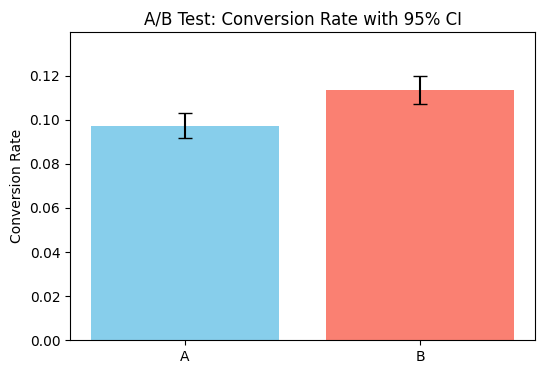

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(
    results['Variant'],
    results['CR (𝑝̂)'],
    yerr=[
        results['CR (𝑝̂)'] - results['CI Lower (95%)'],
        results['CI Upper (95%)'] - results['CR (𝑝̂)']
    ],
    capsize=5,
    color=['skyblue', 'salmon']
)

plt.ylabel('Conversion Rate')
plt.title('A/B Test: Conversion Rate with 95% CI')
plt.ylim(0, max(results['CI Upper (95%)']) + 0.02)
plt.show()

#ST - 4 Z-Test (used in hypothesis testing)


In [ ]:
#4. Two-Proportion z-Test

# Test HO: p_B ≤ p_A vs H1: p_B > P_A

count = np.array([success_B, success_A])

nobs = np.array([n_B, n_A])

z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')

print(f"Z-statistic: {z_stat:.3f}")

print(f"P-value: {p_value:.3f}")

if p_value < 0.05:
  print("→ Reject HO: Variant B has a significantly higher conversion rate.")

else:
  print("→ Fail to reject HO: No significant lift from B over A.")

Z-statistic: 3.708
P-value: 0.000
→ Reject HO: Variant B has a significantly higher conversion rate.


# REAL TIME monitoring and Sequential Testing


In [ ]:
import time
from IPython.display import clear_output

In [ ]:
# Use the same true rates from above
true_p_A, true_p_B = 0.10, 0.12

In [ ]:
# Batch size
batch_size = 100
# Number of batches
n_batches = 60

In [ ]:
# Visitors per batch per variant
visitors_per_variant = batch_size

In [ ]:
# Simulate 60 time steps (e.g. minutes)
n_visits_A = 0
n_visits_B = 0
n_succ_A = 0
n_succ_B = 0

In [ ]:
# Lists to store metrics for plotting
batches = []
p_values = []
lifts = []

In [ ]:
for batch in range(1, n_batches + 1):
    # Simulate one batch of visitors
    new_A = np.random.binomial(batch_size, true_p_A)
    new_B = np.random.binomial(batch_size, true_p_B)

    # Update totals
    n_visits_A += batch_size
    n_visits_B += batch_size

    n_succ_A += new_A
    n_succ_B += new_B

    # Compute current conversion rates
    cr_A = n_succ_A / n_visits_A
    cr_B = n_succ_B / n_visits_B
    lift = cr_B - cr_A

    # Two-proportion z-test (one-sided: B > A)
    count = np.array([n_succ_B, n_succ_A])
    nobs = np.array([n_visits_B, n_visits_A])
    z_stat, p_val = proportions_ztest(count, nobs, alternative='larger')

    # Record for plotting
    batches.append(batch)
    p_values.append(p_val)
    lifts.append(lift)

    # Clear previous output and print current stats
    clear_output(wait=True)
    print(f"Batch {batch}/{n_batches}")
    print(f"Variant A: {n_visits_A} visits, {n_succ_A} buys, CR = {cr_A:.3%}")
    print(f"Variant B: {n_visits_B} visits, {n_succ_B} buys, CR = {cr_B:.3%}")
    print(f"Observed lift: {lift:.3%}")
    print(f"z-stat = {z_stat:.2f}, p-value = {p_val:.4f}")
    if p_val < 0.05:
        print("Significant lift detected (p < 0.05).")
    else:
        print("No significant lift yet.")

Batch 60/60
Variant A: 6000 visits, 574 buys, CR = 9.567%
Variant B: 6000 visits, 714 buys, CR = 11.900%
Observed lift: 2.333%
z-stat = 4.13, p-value = 0.0000
Significant lift detected (p < 0.05).


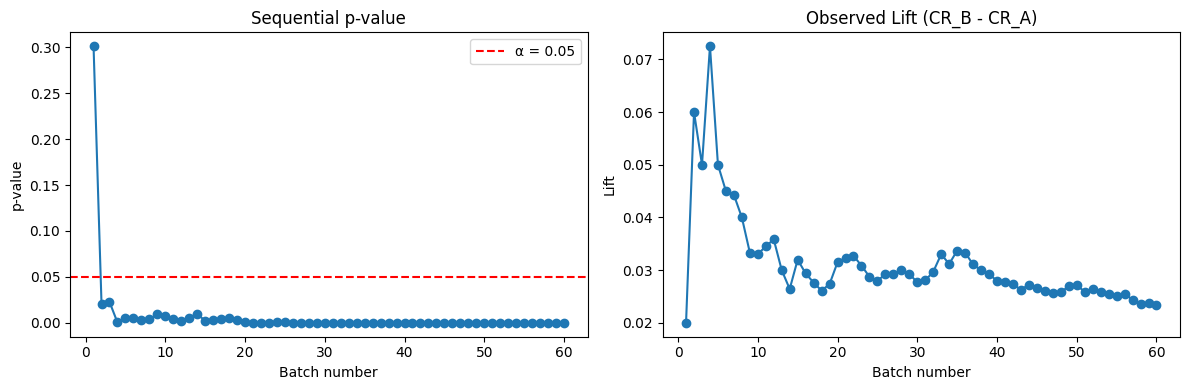

In [ ]:
# Plot p-value and lift over batches
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(batches, p_values, 'o-')
axes[0].axhline(0.05, color='red', linestyle='--', label='α = 0.05')
axes[0].set_title('Sequential p-value')
axes[0].set_xlabel('Batch number')
axes[0].set_ylabel('p-value')
axes[0].legend()

axes[1].plot(batches, lifts, 'o-')
axes[1].set_title('Observed Lift (CR_B - CR_A)')
axes[1].set_xlabel('Batch number')
axes[1].set_ylabel('Lift')

plt.tight_layout()
plt.show()
time.sleep(0.9)